<a href="https://colab.research.google.com/github/marcoplacenti/protein_generation/blob/main/final/redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [291]:
from google.colab import drive
import torch, sys
import pandas as pd
import numpy as np  
from torch import nn
import torch.nn.functional as F
from torchtext import data
import torch.distributions as dist
import random
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [292]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [293]:
cd /content/drive/MyDrive/'Colab Notebooks'/project/

/content/drive/MyDrive/Colab Notebooks/project


In [433]:
def process_data(data, vocab, max_seq):
    token_to_id, id_to_token = {}, {}
    
    token_to_id["<PAD>"] = 0
    id_to_token[0] = "<PAD>"

    token_to_id["<EOS>"] = 1
    id_to_token[1] = "<EOS>"

    token_to_id["<DUMMY>"] = 2
    id_to_token[2] = "<DUMMY>"

    for i, token in enumerate(vocab):
        cum_i = len(token_to_id.keys())
        if token != "<PAD>" and token != "<EOS>" and token != "<DUMMY>":
            token_to_id[token] = cum_i
            id_to_token[cum_i] = token
            cum_i += 1

    seq = []
    for record in data.values:
        tags = record[:-1]
        sequence = record[-1]
        
        encoded_record = [token_to_id[tag] for tag in tags]

        for char in sequence:
            encoded_record.append(token_to_id[char])
        #encoded_record.append(token_to_id["<EOS>"])
        
        if len(sequence) < max_seq:
            for i in range(max_seq-len(sequence)):
                encoded_record.append(token_to_id["<PAD>"])

        seq.append(encoded_record)

    return np.array(seq), token_to_id, id_to_token

In [295]:
def get_data(dataset):
    data = pd.read_csv(dataset)

    data = data.replace(np.nan, '<DUMMY>', regex=True)
    #data.drop("Unnamed: 0", axis=1, inplace=True)
    #data.drop("Entry", axis=1, inplace=True)
    #print(data.columns)
    max_length = int(data['Sequence'].str.len().max())
    data = data[data["Sequence"].map(len) <= max_length]
    vocab = set()
    for col in data.columns:
        if col != "Sequence":
            vocab.update(data[col])

    seq_len = []
    max_seq = 0
    for seq in data["Sequence"]:
        seq = [s for s in seq]
        seq_len.append(len(seq))
        if len(seq) > max_seq:
            max_seq = len(seq)
        vocab.update(seq)

    vocab.update(["<PAD>"])
    vocab.update(["<EOS>"])

    return data, vocab, max_seq

In [477]:
class ProGen(nn.Module):
  
  def __init__(self, hid_size, vocab_size, n_head, n_layers, pf_size, max_len, device):
    super().__init__()

    self.device = device
    self.hid_size = hid_size
    self.pf_size = pf_size
    self.max_len = max_len
    self.embedding = nn.Embedding(vocab_size, hid_size)
    self.position_enc = nn.Embedding(self.max_len, self.hid_size)
    self.position_enc.weight.data = self.position_encoding_init(self.max_len, self.hid_size)
    self.scale = torch.sqrt(torch.FloatTensor([self.hid_size])).to(device)

    self.layer_norm = nn.LayerNorm(self.hid_size)
    self.decoder_layer = nn.TransformerDecoderLayer(d_model=hid_size, nhead = n_head, dim_feedforward=self.pf_size)
    self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_layers, norm=self.layer_norm)
    self.fc = nn.Linear(hid_size, vocab_size)
    self._init_weights()
  
  def forward(self, x):
    sent_len, batch_size = x.shape[0], x.shape[1]
    memory_mask = self.generate_complete_mask(sent_len)
    tgt_mask = self.generate_triangular_mask(sent_len)
    memory = torch.zeros(1, batch_size, self.hid_size, device=self.device)

    temp = x
    temp = self.embedding(temp)

    pos = torch.arange(0,sent_len).unsqueeze(1).repeat(1,batch_size).to(self.device)
    temp_pos_emb = self.position_enc(pos)

    temp = temp * self.scale + temp_pos_emb
    temp = self.decoder(temp, memory, tgt_mask=tgt_mask)
    temp = self.fc(temp)
    return temp

  def _init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def append_decoder_layer(self):
    appended_mod = nn.TransformerDecoderLayer(d_model=hid_size, nhead = n_head).to(self.device)
    for p in appended_mod.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    model.decoder.layers.append(appended_mod)
    model.decoder.num_layers += 1

  def generate_triangular_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
        return
        
  def generate_complete_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = torch.empty(size, size).to(device)
        mask.fill_(float('-inf'))
        return mask

  def generate_sequence(self, src):
    #src = [sent_len]
    src = src.unsqueeze(1)
    #src = [sent_len, 1]
    generate_step = 0
    while generate_step < 120:
      out = self.forward(src)
      #out = [sent_len + 1, 1, vocab_size]
      out = torch.argmax(out[-1, :], dim=1) # [1]
      out = out.unsqueeze(0) #[1,1]
      src = torch.cat((src, out), dim=0)
      generate_step += 1
    src = src.squeeze(1)
    return src
  
  def position_encoding_init(self, n_position, d_pos_vec):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2*i/d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    temp = torch.from_numpy(position_enc).type(torch.FloatTensor)
    temp = temp.to(self.device)
    return temp

In [297]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [455]:
file = "dataset.csv"

data, vocab, max_seq = get_data(file)
seq, token_to_id, id_to_token = process_data(data, vocab, max_seq)
tags_end=1#data.columns.get_loc("Sequence")
aa_read=0

In [466]:
vocab_size = len(vocab)
hid_size = 32
pf_size = 16
max_len = 120
n_head = 4
n_layer= 8
model = ProGen(hid_size, vocab_size, n_head, n_layer, pf_size, max_len, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 161,122 trainable parameters


In [467]:
max_len=seq.shape[1] 

# Preprocess strings into tensors of char ascii indexes
inputs  = torch.zeros((len(seq), max_len)).to(torch.long).to(device)
targets = torch.zeros((len(seq), max_len)).to(torch.long).to(device)

for i, word in enumerate(seq):
    inputs[i,  0:len(word)]   = torch.from_numpy(word)
    targets[i, tags_end+aa_read:] = torch.from_numpy(word[tags_end+aa_read:])
    targets[i, len(word)-1]   = 1  # <EOS> token

# Split into train and test dataset
combined = torch.stack([inputs, targets], dim=1)
train_size = int(0.8 * len(combined))
test_size = len(combined) - train_size
train_ds, test_ds = torch.utils.data.random_split(combined, [train_size, test_size])

train_x, train_y = combined[train_ds.indices][:, 0, :], combined[train_ds.indices][:, 1, :]
test_x, test_y   = combined[test_ds.indices][:, 0, :],  combined[test_ds.indices][:, 1, :]

In [468]:
stats = { 'epoch':[], 'train_loss': [], 'train_perplexity': [], 'test_loss': [], 'test_perplexity': [] }
batch_size, epochs, clip = 16, 50, 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss()

for i in range(epochs):
  model.train()
  idxs = torch.randint(size=(batch_size,), low=0, high=len(train_x))
  src = train_x[idxs]
  trg = train_y[idxs]
  output = model(src)
  optimizer.zero_grad()
  loss = criterion(output.view(-1, output.size(-1)), trg.view(-1))
  nn.utils.clip_grad_norm_(model.parameters(), clip)
  loss.backward()
  optimizer.step()
  stats['train_loss'].append(loss.item())
  stats['epoch'].append(i)
  print(i, loss.item())

0 7.063000679016113
1 6.5903449058532715
2 6.242940902709961
3 5.607173442840576
4 5.2226786613464355
5 4.7251362800598145
6 4.290638446807861
7 3.961808204650879
8 3.6334004402160645
9 3.3569600582122803
10 3.1745893955230713
11 3.0178823471069336
12 2.8997130393981934
13 2.8201217651367188
14 2.721745014190674
15 2.6656618118286133
16 2.7201120853424072
17 2.5644783973693848
18 2.512864589691162
19 2.5231502056121826
20 2.5379514694213867
21 2.543693780899048
22 2.495420217514038
23 2.4478678703308105
24 2.5313730239868164
25 2.445011615753174
26 2.408094882965088
27 2.431363821029663
28 2.44454026222229
29 2.483577251434326
30 2.4214274883270264
31 2.4991891384124756
32 2.408017635345459
33 2.422708749771118
34 2.431666851043701
35 2.42036771774292
36 2.4477670192718506
37 2.4012019634246826
38 2.4095044136047363
39 2.4028615951538086
40 2.4413394927978516
41 2.4790995121002197
42 2.5486178398132324
43 2.3796942234039307
44 2.424682378768921
45 2.450481414794922
46 2.433381080627441

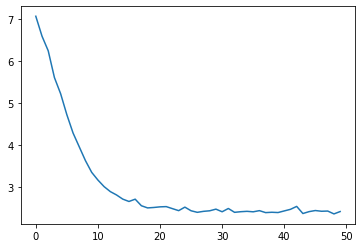

In [470]:
import matplotlib.pyplot as plt
plt.plot(stats['epoch'], stats['train_loss'])
plt.show()

In [475]:
test_x[1,50:]

tensor([  2,   2,   2,   2,   2,   2,   2,   2,   2,   2, 492, 426, 426, 832,
        607, 671, 144, 174, 933, 426, 607, 426,  84, 607, 426, 607,  45, 426,
        607, 426,  45, 607, 164, 933, 607,  84,  40,  84, 806, 144, 144, 671,
        144, 551, 956, 144, 164, 551,  40,  84, 144, 144, 551, 551, 607,  84,
        671, 806, 806, 933,  84, 607, 100,  28, 806, 832, 956, 607, 832, 933,
        100, 475, 100, 806, 164, 671, 100, 901,  84, 475, 551,  40, 426, 426,
         84, 551, 607, 607, 572, 164, 164,  40, 956, 956, 100,  40, 475, 100,
        901, 100, 806,  40,  40, 901, 806, 492, 174,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])